In [1]:
# OCV 도출 (낮은 C-Rate 충방전)

import pandas as pd
import os

modules = pd.read_csv("2st_total_experiment_modules.csv", index_col=0)
rack = pd.read_excel("(220406)KETI 시험의뢰#1_2차시험_랙 데이터.xlsx", index_col = 0)
rack2 = pd.read_excel("(220406)KETI 시험의뢰#1_2차시험_랙 데이터_보정.xlsx", index_col = 0)

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\pandas\core\indexing.py:719: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  indexer = self._get_setitem_indexer(key)
c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\juhyeong\AppData\Local\Temp/ipykernel_17164/1308004484.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

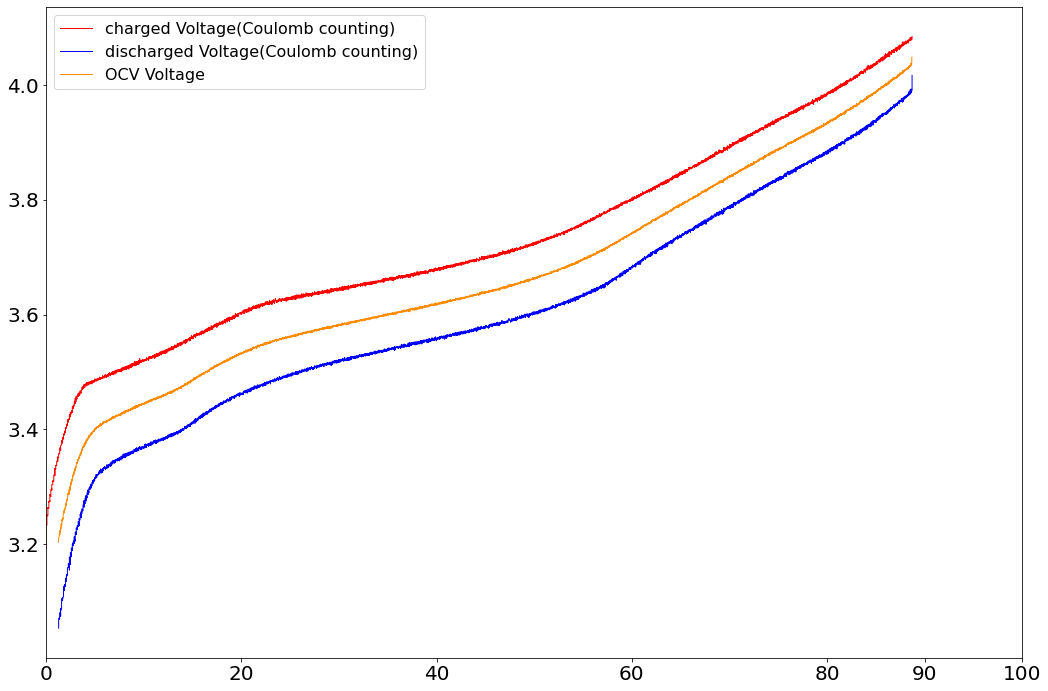

In [4]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpl_toolkits import axisartist
import matplotlib.pylab as plt

def extract_ocv(charge,discharge):
    charge["Coulomb counting SOC"] = charge["Coulomb counting SOC"].astype('float').round(2)#.drop_duplicates()
    discharge["Coulomb counting SOC"] = discharge["Coulomb counting SOC"].sort_values().astype('float').round(2)#.drop_duplicates()

    charge = charge.drop_duplicates(["Coulomb counting SOC"])
    discharge = discharge.drop_duplicates(["Coulomb counting SOC"])

    set_idx_charge = charge.set_index(charge["Coulomb counting SOC"]).drop(["Coulomb counting SOC"],axis=1)
    set_idx_discharge = discharge.set_index(discharge["Coulomb counting SOC"]).drop(["Coulomb counting SOC"],axis=1)

    ocv = pd.concat([set_idx_charge,set_idx_discharge], axis=1).dropna(axis=0)
    
    ocv["ocv Voltage"] = (ocv["charge Voltage"] + ocv["discharge Voltage"]) / 2

    return ocv

## 전류적산법으로 SOC 추정 후 OCV 산정

plt.rcParams['figure.figsize'] = [16, 10]

fig, ax1 = plt.subplots(figsize=(16,10))

plt.rc('font', size=20) 

# 충전 시작시간, 마치는 시간
charge_start = "2022-04-06 10:24:24"
charge_end = "2022-04-06 14:34:46"

# 방전 시작시간, 마치는 시간
discharge_start = "2022-04-06 15:34:45"
discharge_end = "2022-04-06 19:47:57"

start_idx = 4164 # 시작하는 index(2022-04-06 10:24:24)
end_idx = 41698  # 끝나는 index(2022-04-06 19:47:57)

#plt.plot(rack.index, rack["RACK_SOC"], color='black', label="incell SOC")
#plt.plot(rack2.index, rack2["RACK_SOC"], color='black', label="correct a SOC", linestyle="--")


# 전류적산법으로 SOC 추정
coulomb_counting = pd.DataFrame(index = rack.index, columns=["Coulomb counting SOC","mean Voltage"])
coulomb_counting.loc[:start_idx,"Coulomb counting SOC"] = rack.iloc[:start_idx]["RACK_SOC"]

for i in range(start_idx,end_idx+1):
    coulomb_counting.iloc[i]["Coulomb counting SOC"] = coulomb_counting.iloc[i-1]["Coulomb counting SOC"] + rack.iloc[i]["RACK_CURRENT"]/60/3600/3.75*100

coulomb_counting.loc[:,"mean Voltage"] = (rack[:]["MIN_CELL_VOLT"] + rack[:]["MAX_CELL_VOLT"]) / 2 # 전류적산법 산정

charge = coulomb_counting[charge_start:charge_end]          # 충전 부분
discharge = coulomb_counting[discharge_start:discharge_end] # 방전 부분

charge.rename(columns = {'mean Voltage':'charge Voltage'},inplace=True)
discharge.rename(columns = {'mean Voltage':'discharge Voltage'},inplace=True)

plt.plot(charge["Coulomb counting SOC"].astype('float').round(1), 
         charge["charge Voltage"], 
         label="charged Voltage(Coulomb counting)", color='red', linewidth=1) # 충전 부분 출력(그림의 빨간 선)

plt.plot(discharge["Coulomb counting SOC"].astype('float').round(1), 
         discharge["discharge Voltage"], 
         label="discharged Voltage(Coulomb counting)", color='blue', linewidth=1) # 방전 부분 출력(그림의 파란 선)

ocv_data = extract_ocv(charge,discharge) # OCV 채우기

plt.plot(ocv_data.index, ocv_data["ocv Voltage"],
         label="OCV Voltage", color='darkorange', linewidth=1) # OCV 출력(주황 선)

#ocv_idx = coulomb_counting[charge_start:charge_end]["Coulomb counting SOC"] == coulomb_counting[discharge_start:discharge_end]["Coulomb counting SOC"]

#ocv = coulomb_counting[charge_start:charge_end]["Coulomb counting SOC"] == coulomb_counting[discharge_start:discharge_end]["Coulomb counting SOC"]

plt.xticks([0,20,40,60,80,90,100])
plt.xlim([0,100])
#ax1.set_ylabel("State-of-Charge(SoC, %)")
#ax1.set_yticks([0,20,40,60,80,100])
#ax1.set_ylim([0,100])

plt.tight_layout()
plt.legend(fontsize = 16)

plt.subplots_adjust(right=0.9)
plt.savefig("./2st_fig/rack/rack OCV(Coulomb counting).jpg", dpi=256)

c:\users\juhyeong\desktop\rack_analysis\.venv\lib\site-packages\pandas\core\frame.py:5039: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
C:\Users\juhyeong\AppData\Local\Temp/ipykernel_17164/829781516.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  charge["Coulomb counting SOC"] = charge["Coulomb counting SOC"].astype('float').round(2)#.drop_duplicates()
C:\Users\juhyeong\AppData\Local\Temp/ipykernel_17164/829781516.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

                     Coulomb counting SOC  discharge Voltage
                                                            
2022-04-06 19:47:56                   0.0              3.054
                     Coulomb counting SOC  discharge Voltage
                                                            
2022-04-06 19:47:56                   0.0              3.054
                     Coulomb counting SOC  discharge Voltage
                                                            
2022-04-06 19:42:36                   1.0             3.2235


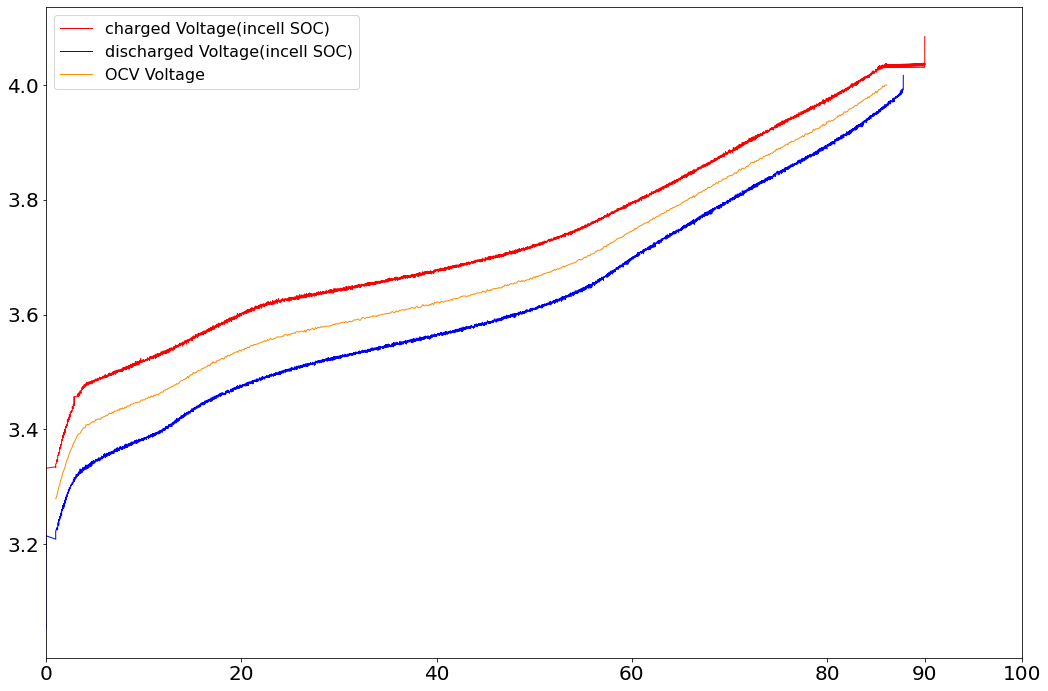

In [12]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
from mpl_toolkits import axisartist
import matplotlib.pylab as plt

def extract_ocv(charge,discharge):

    charge["Coulomb counting SOC"] = charge["Coulomb counting SOC"].astype('float').round(2)#.drop_duplicates()
    discharge["Coulomb counting SOC"] = discharge["Coulomb counting SOC"].sort_values().astype('float').round(2)#.drop_duplicates()

    charge = charge.drop_duplicates(["Coulomb counting SOC"])
    discharge = discharge.drop_duplicates(["Coulomb counting SOC"])

    set_idx_charge = charge.set_index(charge["Coulomb counting SOC"]).drop(["Coulomb counting SOC"],axis=1)
    set_idx_discharge = discharge.set_index(discharge["Coulomb counting SOC"]).drop(["Coulomb counting SOC"],axis=1)

    ocv = pd.concat([set_idx_charge,set_idx_discharge], axis=1).dropna(axis=0)
    
    ocv["ocv Voltage"] = (ocv["charge Voltage"] + ocv["discharge Voltage"]) / 2
    
    return ocv

## 인셀 SOC로 OCV 산정

plt.rcParams['figure.figsize'] = [16, 10]

fig, ax1 = plt.subplots(figsize=(16,10))

plt.rc('font', size=20) 

charge_start = "2022-04-06 10:24:24"
charge_end = "2022-04-06 14:34:46"

discharge_start = "2022-04-06 15:34:45"
discharge_end = "2022-04-06 19:47:57"

start_idx = 4164
end_idx = 41698

#plt.plot(rack.index, rack["RACK_SOC"], color='black', label="incell SOC")
#plt.plot(rack2.index, rack2["RACK_SOC"], color='black', label="correct a SOC", linestyle="--")


voltaged = pd.DataFrame(index = rack.index, columns=["Coulomb counting SOC","mean Voltage"])
voltaged["Coulomb counting SOC"] = rack["RACK_SOC"]

voltaged["mean Voltage"] = (rack["MIN_CELL_VOLT"] + rack["MAX_CELL_VOLT"]) / 2

charge = voltaged[charge_start:charge_end]
discharge = voltaged[discharge_start:discharge_end]

charge.rename(columns = {'mean Voltage':'charge Voltage'},inplace=True)
discharge.rename(columns = {'mean Voltage':'discharge Voltage'},inplace=True)

plt.plot(charge["Coulomb counting SOC"].astype('float').round(1), 
         charge["charge Voltage"], 
         label="charged Voltage(incell SOC)", color='red', linewidth=1)

plt.plot(discharge["Coulomb counting SOC"].astype('float').round(1), 
         discharge["discharge Voltage"], 
         label="discharged Voltage(incell SOC)", color='blue', linewidth=1)

ocv_data = extract_ocv(charge,discharge)[1:]

plt.plot(ocv_data.index, ocv_data["ocv Voltage"],
         label="OCV Voltage", color='darkorange', linewidth=1)

#ocv_idx = coulomb_counting[charge_start:charge_end]["Coulomb counting SOC"] == coulomb_counting[discharge_start:discharge_end]["Coulomb counting SOC"]

#ocv = coulomb_counting[charge_start:charge_end]["Coulomb counting SOC"] == coulomb_counting[discharge_start:discharge_end]["Coulomb counting SOC"]

plt.xticks([0,20,40,60,80,90,100])
plt.xlim([0,100])
#ax1.set_ylabel("State-of-Charge(SoC, %)")
#ax1.set_yticks([0,20,40,60,80,100])
#ax1.set_ylim([0,100])

plt.tight_layout()
plt.legend(fontsize = 16)

plt.subplots_adjust(right=0.9)
plt.savefig("./2st_fig/rack/rack OCV(incell SOC).jpg", dpi=256)

In [11]:
ocv_data

,charge Voltage,discharge Voltage,ocv Voltage
Coulomb counting SOC,,,
0.0,3.1930,3.2150,3.20400
1.0,3.3350,3.2235,3.27925
1.1,3.3415,3.2255,3.28350
1.2,3.3440,3.2375,3.29075
1.3,3.3565,3.2415,3.29900
...,...,...,...
85.7,4.0345,3.9620,3.99825
85.8,4.0300,3.9630,3.99650
85.9,4.0345,3.9625,3.99850


In [8]:
charge

,Coulomb counting SOC,charge Voltage
,,
2022-04-06 10:24:24,0.0,3.1930
2022-04-06 10:24:25,0.0,3.2135
2022-04-06 10:24:26,0.0,3.2135
2022-04-06 10:24:27,0.0,3.2185
2022-04-06 10:24:28,0.0,3.2185
...,...,...
2022-04-06 14:34:42,90.0,4.0820
2022-04-06 14:34:43,90.0,4.0835
2022-04-06 14:34:44,90.0,4.0835
